# Compare scEGOT and PAGA

# Input & Preprocessings

In [1]:
out_dir = "output"
target_sum = 1e5
RANDOM_STATE = 0

In [2]:
import os
import glob
import itertools
import pandas as pd
from scegot import scEGOT
import numpy as np
import anndata
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import check_random_state
import matplotlib
import scvelo as scv
import adjustText
import scipy
import scipy.stats
import scanpy as sc

In [3]:
file_name = "../data/scRNAseq_hPGCLC_induction_Saitou.h5ad"
adata = anndata.read_h5ad(file_name)
adata

AnnData object with n_obs × n_vars = 11771 × 18922
    obs: 'sample', 'percent.mito', 'day', 'cluster_day'
    var: 'spliced', 'unspliced', 'mt', 'TF', 'gene_name'
    layers: 'X_raw', 'spliced', 'unspliced'

In [4]:
display(adata.obs)
display(adata.var)

sample  percent.mito  day cluster_day
iM.data_GTGGAAGGTCAATGGG-1    iM.data      0.056487   iM        day0
iM.data_TTCATGTCAACCCGCA-1    iM.data      0.216231   iM        day0
iM.data_GAGGGTATCCAGGACC-1    iM.data      0.076525   iM        day0
iM.data_AAGTCGTAGGCTTTCA-1    iM.data      0.080264   iM        day0
iM.data_ACCGTTCGTAACTTCG-1    iM.data      0.280788   iM        day0
...                               ...           ...  ...         ...
d2b.data_AAGCCATAGGGCGAGA-1  d2b.data      4.811476  d2b        day2
d2b.data_CAACCAATCTTCCGTG-1  d2b.data      2.554428  d2b        day2
d2b.data_AGGCCACGTGAGTAGC-1  d2b.data      3.142146  d2b        day2
d2b.data_GATCAGTTCGAGTACT-1  d2b.data      4.287140  d2b        day2
d2b.data_TCATCCGTCATGGGAG-1  d2b.data      2.835834  d2b        day2

[11771 rows x 4 columns]

spliced  unspliced  mt  TF gene_name
FAM3A           1          1   0   0     FAM3A
SLC25A1         1          1   0   0   SLC25A1
RBL1            1          1   0   0      RBL1
PPP2R1A         1          1   0   0   PPP2R1A
H3F3B           1          1   0   0     H3F3B
...           ...        ...  ..  ..       ...
OR2W5           1          0   0   0     OR2W5
ODF4            1          1   0   0      ODF4
CRP             1          0   0   0       CRP
KRTAP4-9        1          0   0   0  KRTAP4-9
THEMIS          1          1   0   0    THEMIS

[18922 rows x 5 columns]

In [5]:
marker_genes = [
    "NANOG",
    "SOX17",
    "TFAP2C",
    "PRDM1",
    "EOMES",
    "TFAP2A",
    "NKX1-2",
    "GATA3",
    "GATA4",
    "GATA6",
    "HAND1",
    "MESP1",
    "MESP2",
    "FOXA2",
    "NKX2-5",
    "FOXF1",
    "POU5F1",
    "TBXT",
    "SOX2",
    "MIXL1",
]

In [6]:
PCA_N_COMPONENTS = 150
GMM_CLUSTER_NUMBERS = [1, 2, 4, 5, 5]
DAY_NAMES = ["day0", "day0.5", "day1", "day1.5", "day2"]

# run scEGOT

In [7]:
scegot = scEGOT(
    adata,
    verbose=True,
    adata_day_key="cluster_day",
)

Processing AnnData...


In [8]:
X, pca_model = scegot.preprocess(
    pca_n_components=PCA_N_COMPONENTS,
    umi_target_sum=1e5,
    pca_random_state=RANDOM_STATE,
)

Applying RECODE...
start RECODE for scRNA-seq data
end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 15820, '#non-significant genes': 2582, '#silent genes': 65, 'ell': 288, 'Elapsed time': '0h 0m 20s 598ms', 'solver': 'randomized', '#test_data': 2354}
Applying UMI normalization...
Applying log1p normalization...
Applying PCA...
	sum of explained_variance_ratio = 93.66772066272378


In [9]:
gmm_models, gmm_labels = scegot.fit_predict_gmm(
    n_components_list=GMM_CLUSTER_NUMBERS,
    random_state=RANDOM_STATE,
)

Fitting GMM models with each day's data and predicting labels for them...


100%|██████████| 5/5 [00:19<00:00,  3.91s/it]


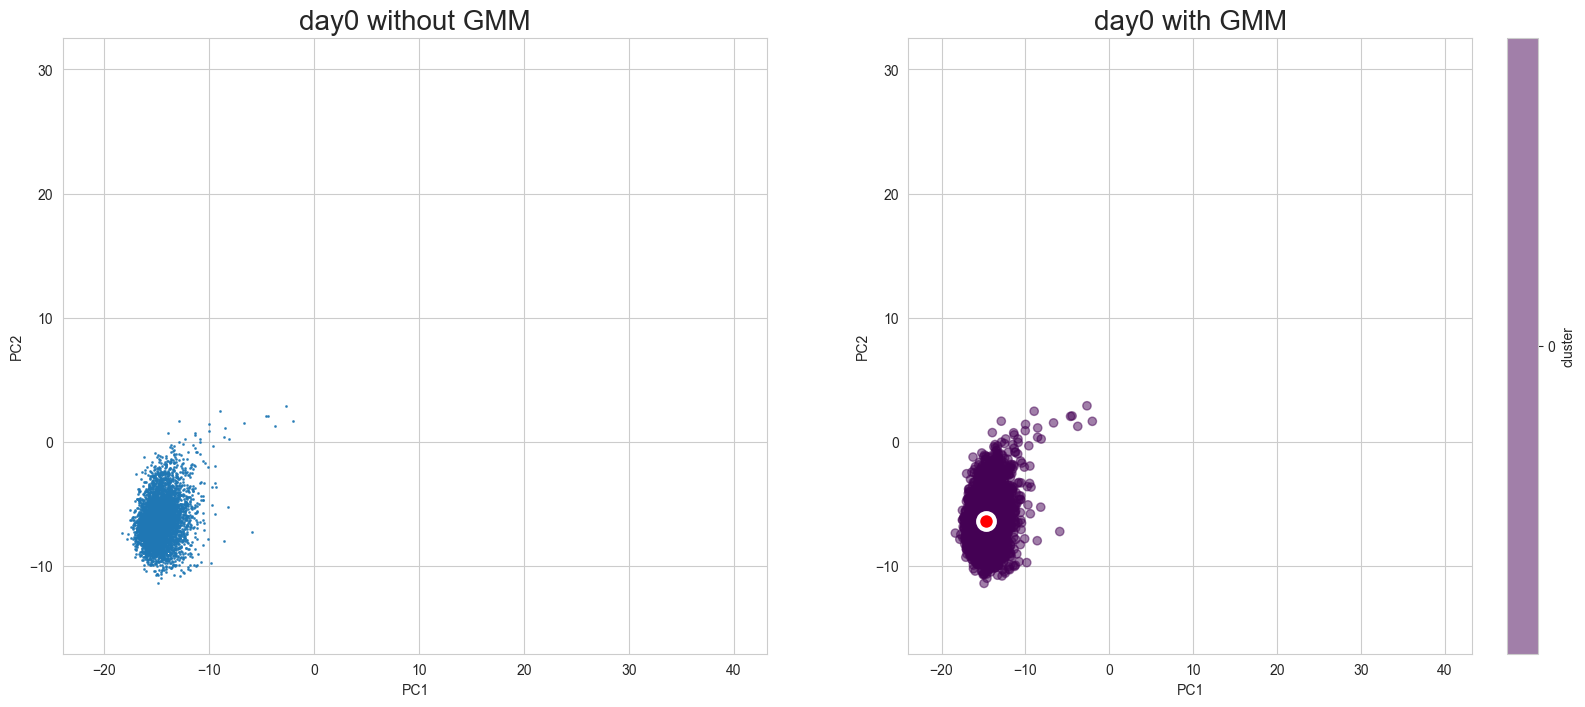

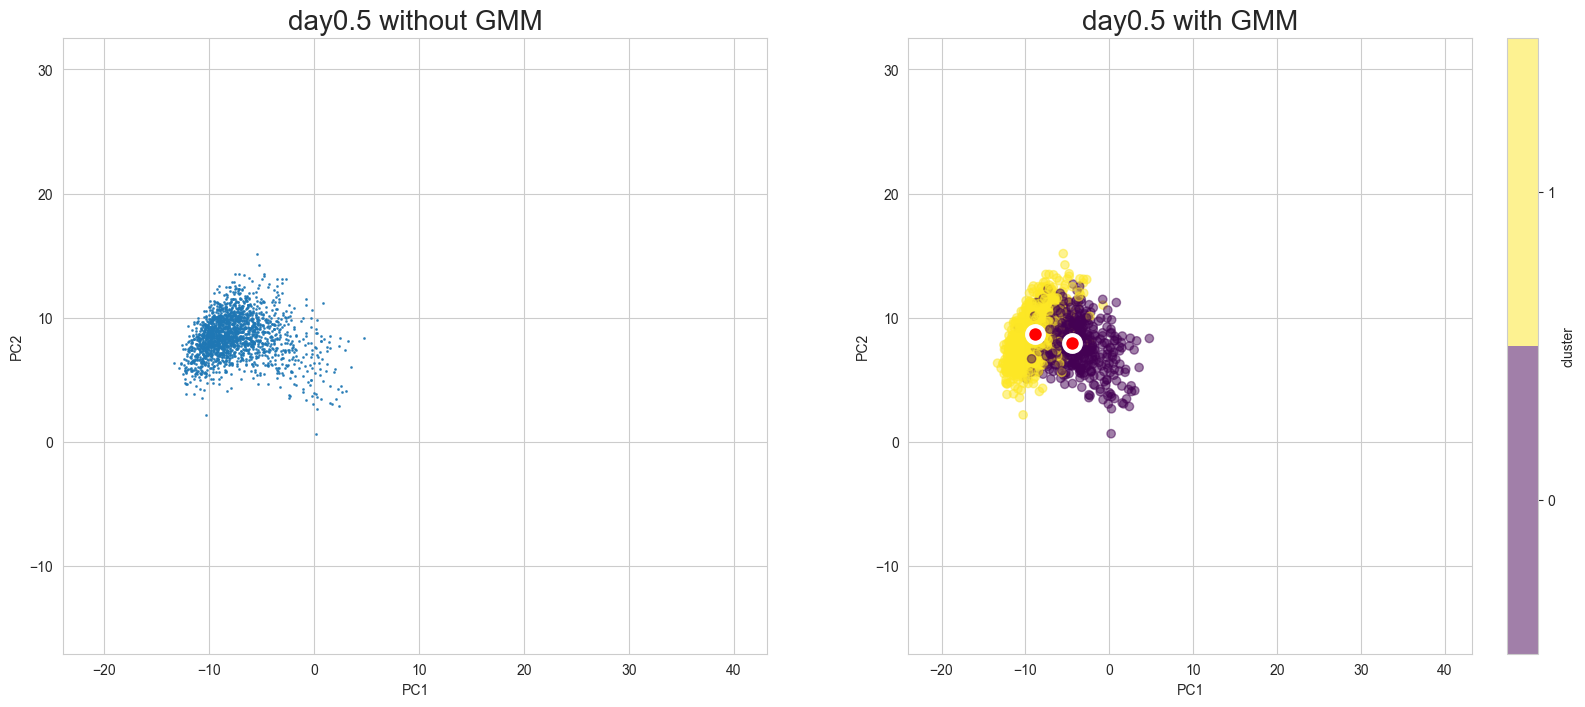

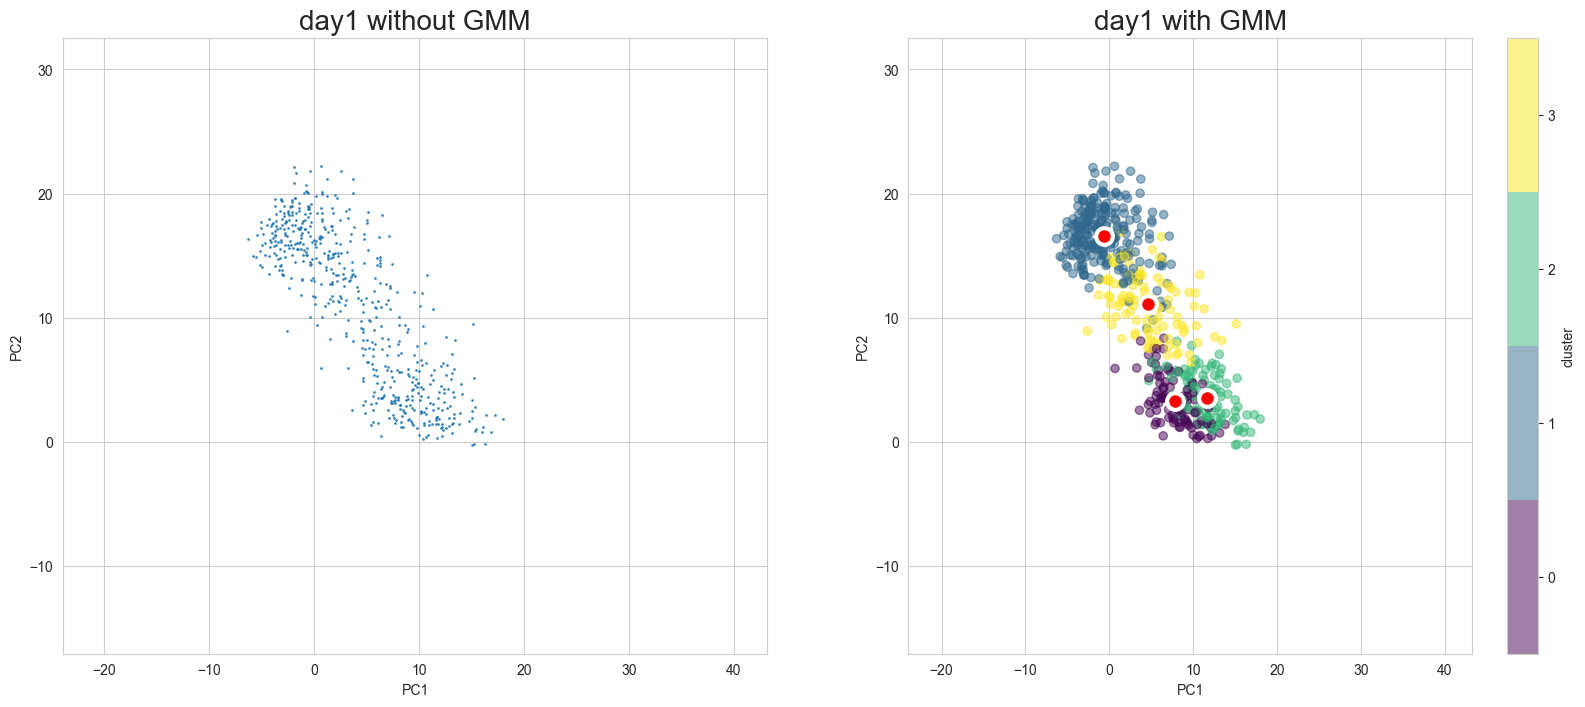

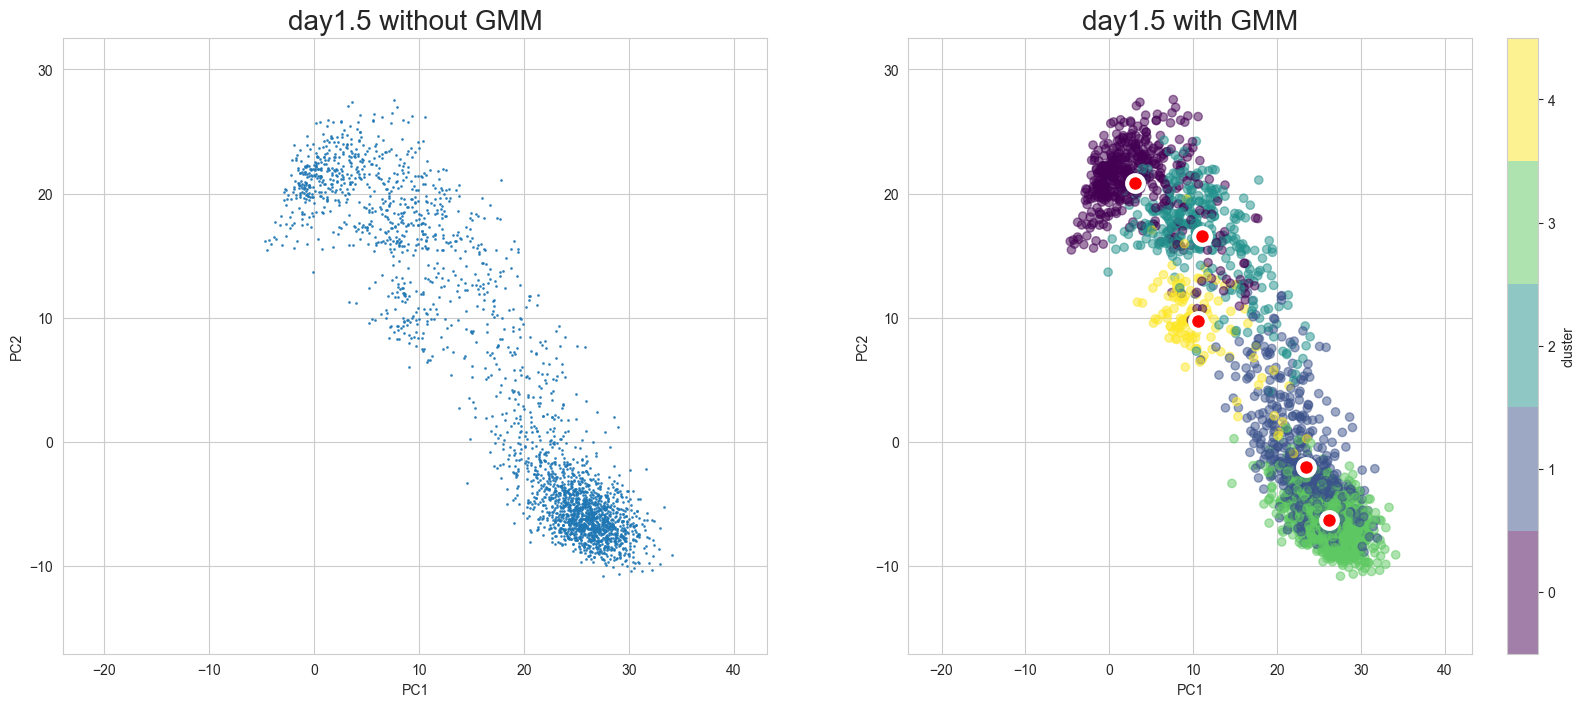

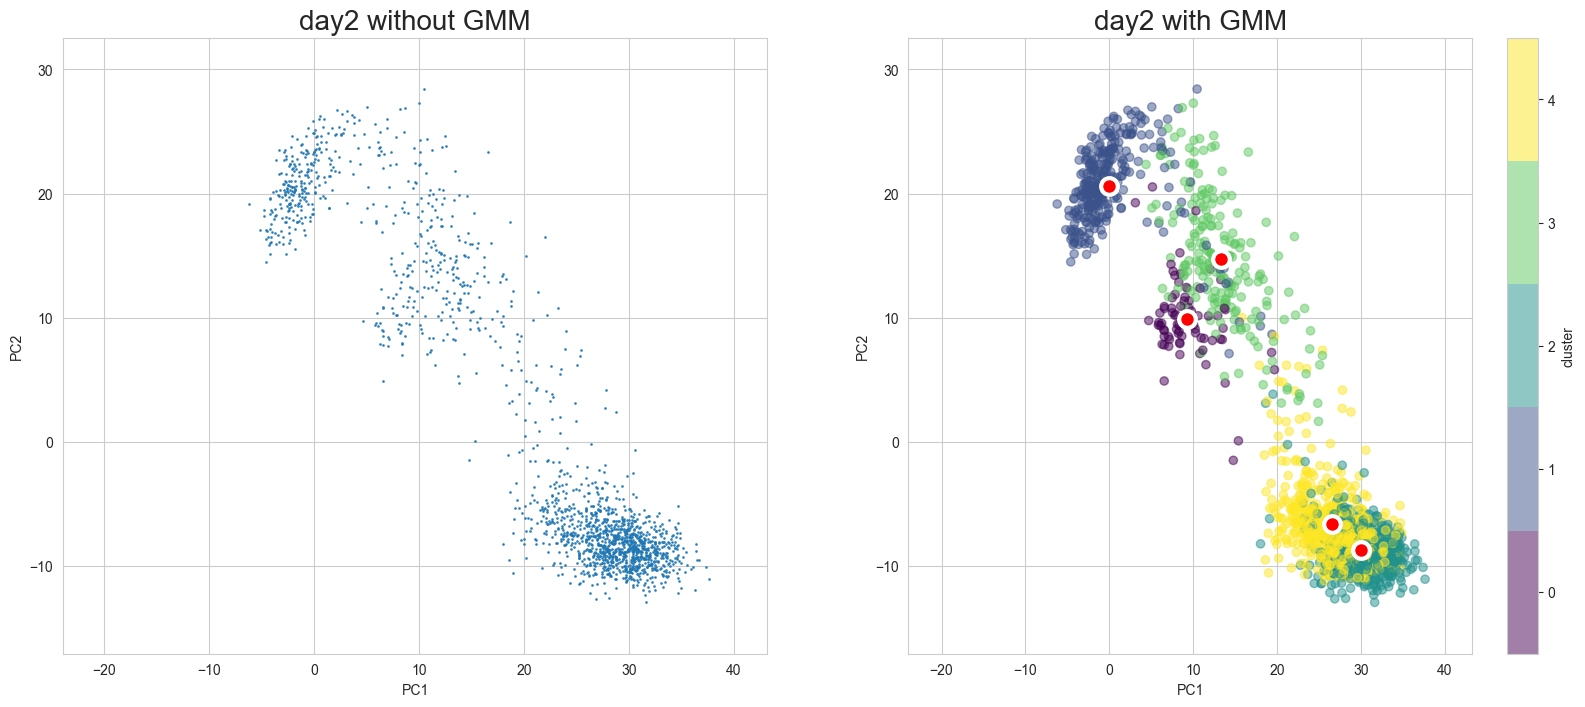

In [10]:
scegot.plot_gmm_predictions(
    mode="pca",
    plot_gmm_means=True,
    figure_titles_without_gmm=[f"{name} without GMM" for name in DAY_NAMES],
    figure_titles_with_gmm=[f"{name} with GMM" for name in DAY_NAMES],
    cmap="viridis",
    save=False,
)

## Sort clusters

In [11]:
gmm_labels_convert = [
    [0],
    [1, 0],
    [2, 0, 3, 1],
    [0, 3, 1, 4, 2],
    [2, 0, 4, 1, 3],
]
scegot.replace_gmm_labels(gmm_labels_convert)

# GMM

### FigS GM dist on PCA

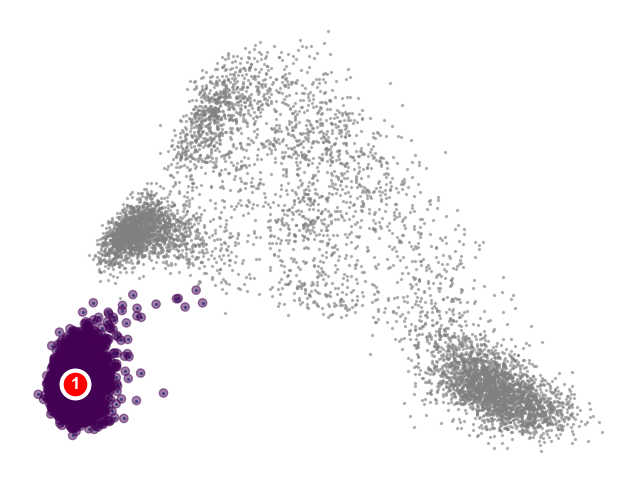

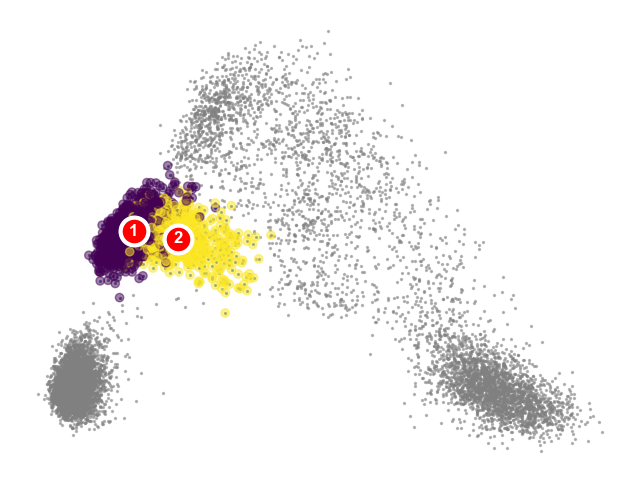

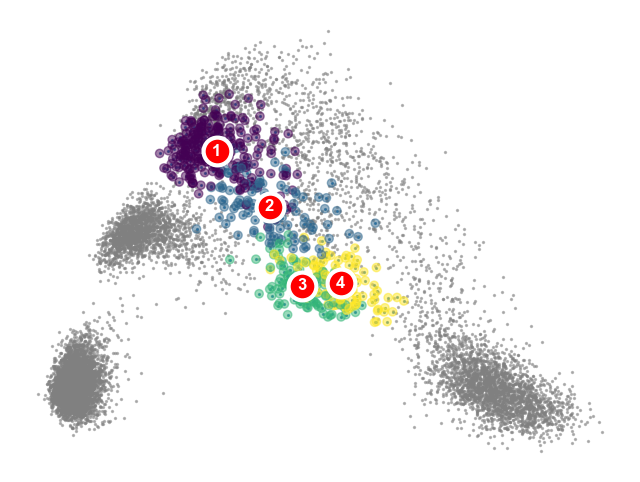

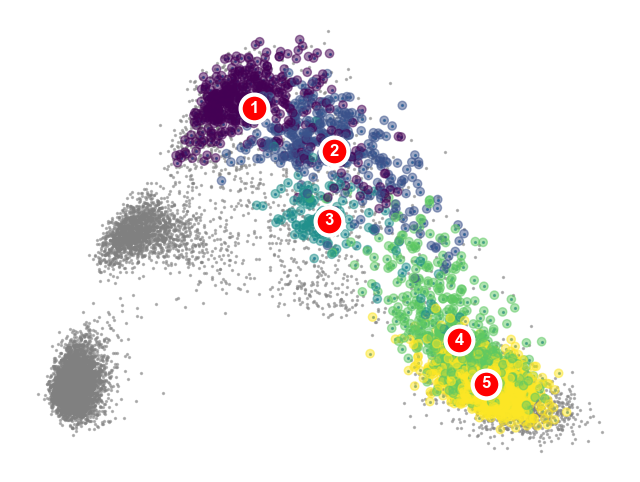

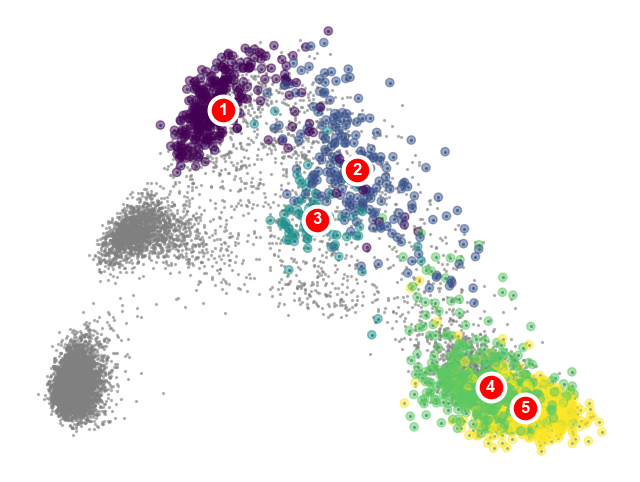

In [12]:
figure_labels = None
plot_gmm_means = False
plot_gmm_means = True
cmap = "viridis"
save = True
DAY_LIST_WITH_DECIMAL_POINT = ["0", "0.5", "1", "1.5", "2"]
FIGURE_NAMES_BY_DAY = [f"Day{day}" for day in DAY_LIST_WITH_DECIMAL_POINT]
save_paths = [f"./{out_dir}/Fig_GMM_PCA_{name}.png" for name in FIGURE_NAMES_BY_DAY]


if save and save_paths is None:
    save_paths = [f"./GMM_preds_{i + 1}.png" for i in range(len(X))]

X_all = pd.concat(X).values
i = 0
for i in range(len(X)):
    plt.figure(figsize=(8, 6))
    plt.scatter(X_all[:, 0], X_all[:, 1], color="gray", zorder=0, alpha=0.5, s=2)

    scegot._plot_gmm_predictions(X[i], plt.xlim(), plt.ylim(), figure_labels)

    gmm_model = gmm_models[i]
    X_item = X[i]

    if plot_gmm_means:
        for k in range(scegot.gmm_n_components_list[i]):
            plt.plot(
                gmm_model.means_[k][0],
                gmm_model.means_[k][1],
                "ro",
                markersize=20,
                markeredgewidth=3,
                markeredgecolor="white",
            )

    for k in range(scegot.gmm_n_components_list[i]):
        plt.text(
            gmm_model.means_[k][0],
            gmm_model.means_[k][1],
            str(gmm_labels_convert[i][k] + 1),
            color="white",
            va="center",
            ha="center",
            fontweight="bold",
            fontsize=12,
        )

    gmm_n_components = scegot.gmm_n_components_list[i]
    if gmm_labels is None:
        plt.scatter(X_item.values[:, 0], X_item.values[:, 1], s=0.5, alpha=0.5)
    else:
        plt.scatter(
            X_item.values[:, 0],
            X_item.values[:, 1],
            c=scegot.gmm_labels_modified[i],
            alpha=0.5,
            cmap=plt.cm.get_cmap(cmap, gmm_n_components),
        )

    plt.grid(False)
    plt.axis("off")

    plt.savefig(
        save_paths[i],
        dpi=200,
        bbox_inches="tight",
        transparent=True,
    )

## UMAP

In [13]:
UMAP_N_NEIGHBORS = 15
UMAP_N_COMPONENTS = 2
scegot.umap_n_components = UMAP_N_COMPONENTS
X_umap, umap_model = scegot.apply_umap(
    n_neighbors=UMAP_N_NEIGHBORS,
    random_state=RANDOM_STATE,
    min_dist=0.8,
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## FigS GM dist on UMAP

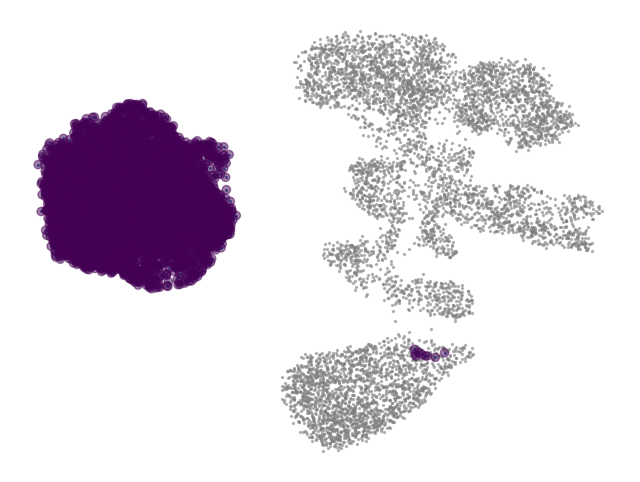

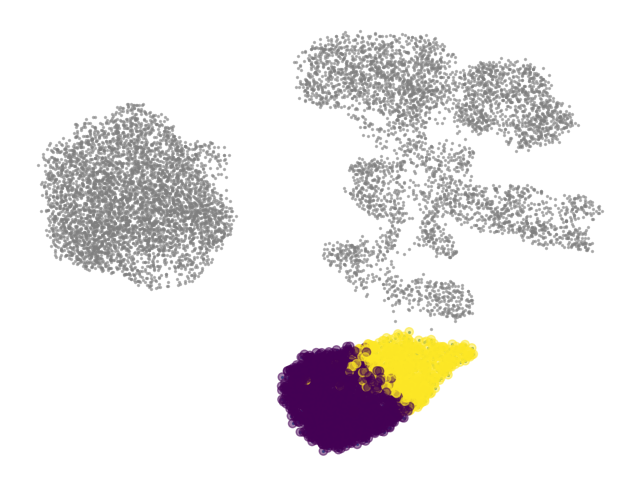

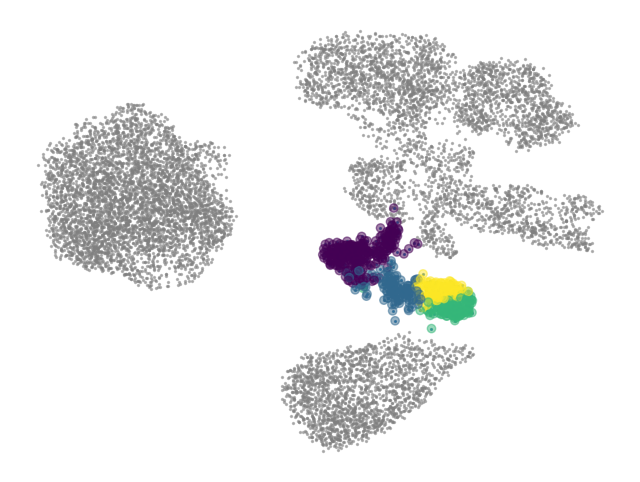

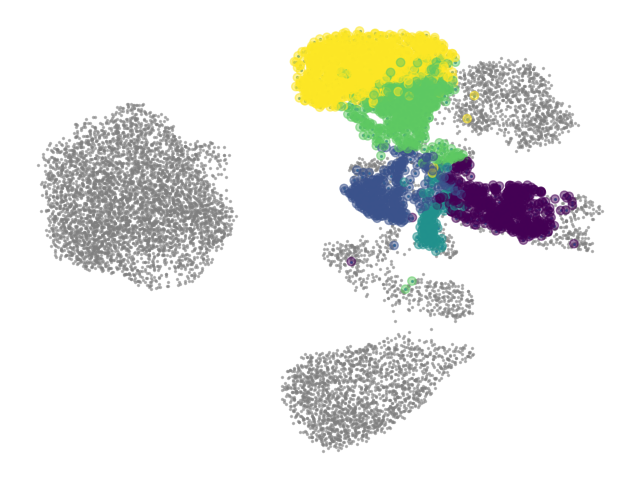

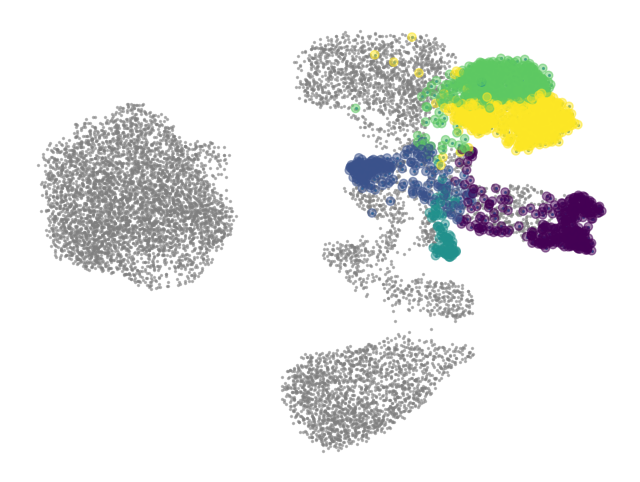

In [14]:
figure_labels = None
plot_gmm_means = False
plot_gmm_means = True
cmap = "viridis"
save = True
save_paths = [f"../figure/Fig_GMM_UMAP_{name}.png" for name in FIGURE_NAMES_BY_DAY]

X_all = pd.concat(X_umap).values
i = 0
for i in range(len(X_umap)):
    plt.figure(figsize=(8, 6))

    plt.scatter(X_all[:, 0], X_all[:, 1], color="gray", zorder=0, alpha=0.5, s=2)

    scegot._plot_gmm_predictions(X_umap[i], plt.xlim(), plt.ylim(), figure_labels)

    gmm_model = gmm_models[i]
    X_item = X_umap[i]

    gmm_n_components = scegot.gmm_n_components_list[i]
    if gmm_labels is None:
        plt.scatter(X_item.values[:, 0], X_item.values[:, 1], s=0.5, alpha=0.5)
    else:
        plt.scatter(
            X_item.values[:, 0],
            X_item.values[:, 1],
            c=scegot.gmm_labels_modified[i],
            alpha=0.5,
            cmap=plt.cm.get_cmap(cmap, gmm_n_components),
        )

    plt.grid(False)
    plt.axis("off")

    if save:
        plt.savefig(
            save_paths[i],
            dpi=200,
            bbox_inches="tight",
            transparent=True,
        )
    plt.show()

# Cluster Annotation

### Fig Days on PCA

(-21.155169188038048,
 40.43478383682285,
 -15.017550864854407,
 30.48877801532716)

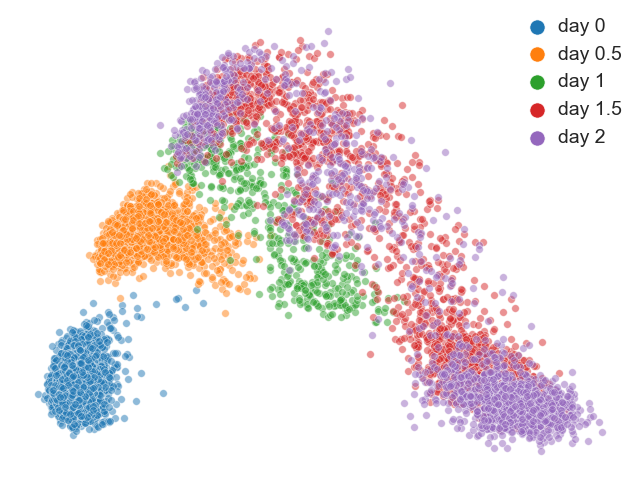

In [15]:
figsize = (8, 6)
size_pt = 30
clusters_ = adata.obs["cluster_day"]
cluster_set_ = DAY_NAMES
plot_data_ = pd.concat(X).values[:, :2]
DAY_NAMES_MOD = ["day 0", "day 0.5", "day 1", "day 1.5", "day 2"]

fig, ax = plt.subplots(figsize=figsize)
for c_ in cluster_set_:
    idx_ = clusters_ == c_
    ax.scatter(
        plot_data_[idx_, 0],
        plot_data_[idx_, 1],
        s=size_pt,
        zorder=2,
        alpha=0.5,
        label=DAY_NAMES_MOD[cluster_set_.index(c_)],
        edgecolors="w",
        linewidth=0.5,
    )
leg = ax.legend(
    fontsize=14,
    markerscale=2,
    borderaxespad=0,
    frameon=False,
    handletextpad=0.1,
    facecolor="w",
)
for lh in leg.legend_handles:
    lh.set_alpha(1)
ax.axis("off")
#fig.savefig("../figure/Fig_pca_days.png", bbox_inches="tight", dpi=200)

### Fig Cell types on PCA

(-21.155169188038048,
 40.43478383682285,
 -15.017550864854407,
 30.48877801532716)

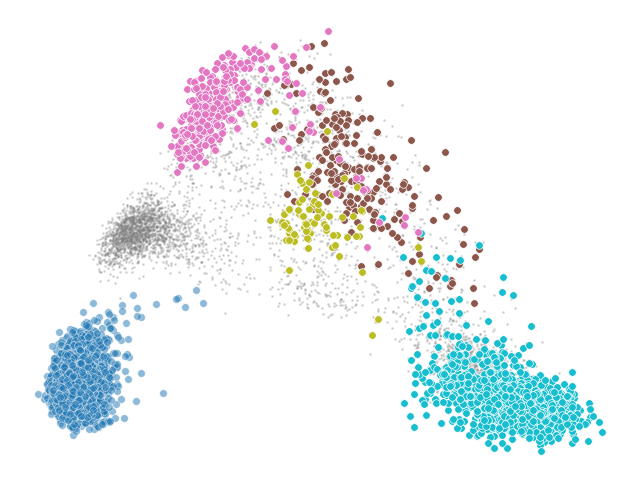

In [16]:
figsize = (8, 6)
size_pt = 30

# cluster_dict = {0: "PGCLC", 1: "ALC", 2: "ALC", 3: "ELC", 4: "LPMLC"}
cluster_dict = {0: "PGCLC", 1: "ALC", 2: "ELC", 3: "LPMLC", 4: "LPMLC"}
clusters_day2 = np.array(
    [
        cluster_dict[gmm_labels_convert[-1][gmm_labels[4][i]]]
        for i in range(len(gmm_labels[4]))
    ]
)

fig, ax = plt.subplots(figsize=figsize)
cluster_set = np.unique(clusters_day2)
data_pca = pd.concat(X[1:-1]).values[:, :2]
color_dict = {
    "ALC": "tab:brown",
    "PGCLC": "tab:pink",
    "ELC": "tab:olive",
    "LPMLC": "tab:cyan",
}
ax.scatter(data_pca[:, 0], data_pca[:, 1], color="gray", s=1, alpha=0.25)
cmap = plt.cm.Accent
for c_ in cluster_set:
    idx_ = clusters_day2 == c_
    ax.scatter(
        X[-1].values[idx_, 0],
        X[-1].values[idx_, 1],
        s=size_pt,
        zorder=2,
        alpha=1,
        facecolor=color_dict[c_],
        edgecolors="w",
        linewidth=0.5,
    )
ax.scatter(
    X[0].values[:, 0],
    X[0].values[:, 1],
    color=plt.cm.tab10(0),
    # facecolor=plt.cm.tab10(9),
    edgecolors="w",
    linewidth=0.5,
    s=size_pt,
    alpha=0.5,
)
ax.axis("off")
#fig.savefig("../figure/Fig_pca_clusters.png", bbox_inches="tight", dpi=200)

### FigS Day on UMAP

(-6.444367861747741,
 19.436876273155214,
 -10.066513299942017,
 18.907500505447388)

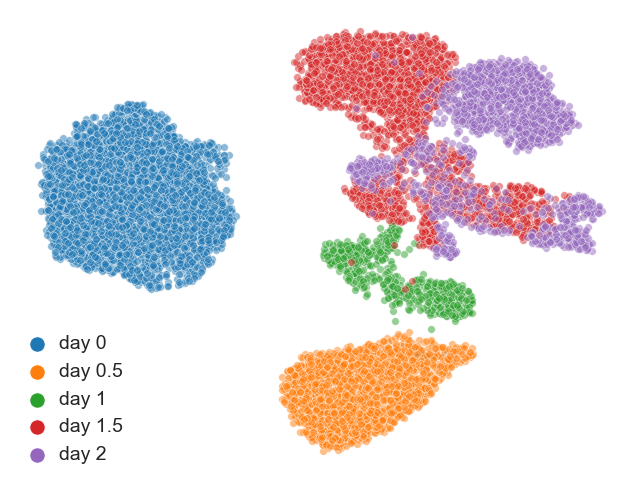

In [17]:
figsize = (8, 6)
size_pt = 30
clusters_ = adata.obs["cluster_day"]
cluster_set_ = DAY_NAMES
plot_data_ = pd.concat(X_umap).values[:, :2]

fig, ax = plt.subplots(figsize=figsize)
for c_ in cluster_set_:
    idx_ = clusters_ == c_
    ax.scatter(
        plot_data_[idx_, 0],
        plot_data_[idx_, 1],
        s=size_pt,
        zorder=2,
        alpha=0.5,
        label=DAY_NAMES_MOD[cluster_set_.index(c_)],
        edgecolors="w",
        linewidth=0.5,
    )
leg = ax.legend(
    fontsize=14,
    markerscale=2,
    borderaxespad=0,
    frameon=False,
    handletextpad=0.1,
    facecolor="w",
)
for lh in leg.legend_handles:
    lh.set_alpha(1)
ax.axis("off")
#fig.savefig("../figure/Fig_umap_days.png", bbox_inches="tight", dpi=200)

### FigS Cell types on UMAP

(-6.444367861747741,
 19.436876273155214,
 -10.066513299942017,
 18.907500505447388)

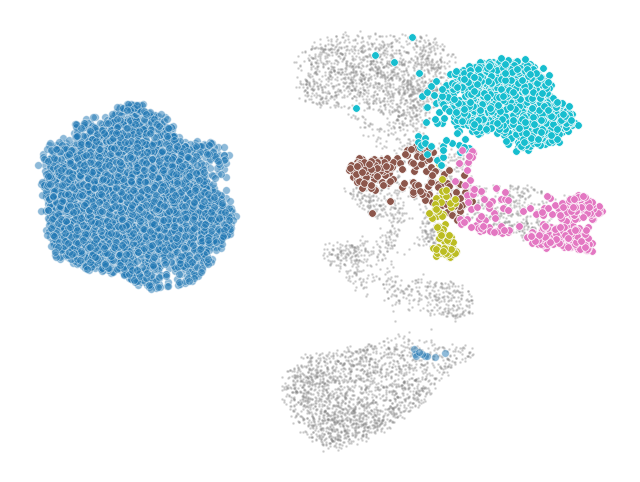

In [18]:
X_plot = X_umap
figsize = (8, 6)
size_pt = 30

fig, ax = plt.subplots(figsize=figsize)
cluster_set = np.unique(clusters_day2)
ax.scatter(
    pd.concat(X_plot[1:-1]).values[:, 0],
    pd.concat(X_plot[1:-1]).values[:, 1],
    color="gray",
    s=1,
    alpha=0.25,
)
cmap = plt.cm.Accent
for c_ in cluster_set:
    idx_ = clusters_day2 == c_
    ax.scatter(
        X_plot[-1].values[idx_, 0],
        X_plot[-1].values[idx_, 1],
        s=size_pt,
        zorder=2,
        alpha=1,
        facecolor=color_dict[c_],
        edgecolors="w",
        linewidth=0.5,
    )
ax.scatter(
    X_plot[0].values[:, 0],
    X_plot[0].values[:, 1],
    color=plt.cm.tab10(0),
    # facecolor=plt.cm.tab10(9),
    edgecolors="w",
    linewidth=0.5,
    s=size_pt,
    alpha=0.5,
)
ax.axis("off")
#fig.savefig("../figure/Fig_umap_clusters.png", bbox_inches="tight", dpi=200)

In [19]:
cluster_celltype_color = np.repeat("tab:blue", X[0].shape[0])
for i in range(3):
    cluster_celltype_color = np.append(
        cluster_celltype_color, np.repeat("tab:gray", X[i + 1].shape[0])
    )
clusters_day2_color = np.empty(clusters_day2.shape, dtype=object)
for c_ in np.unique(clusters_day2):
    clusters_day2_color[clusters_day2 == c_] = str(color_dict[c_])

cluster_celltype_color = np.append(cluster_celltype_color, clusters_day2_color)

cluster_celltype_color.shape

(11771,)

In [20]:
cluster_celltype = np.repeat(0, X[0].shape[0])
for i in range(3):
    cluster_celltype = np.append(
        cluster_celltype, np.ones(X[i + 1].shape[0], dtype=int)
    )
clusters_day2_int = np.empty(clusters_day2.shape, dtype=int)
for c_ in np.unique(clusters_day2):
    clusters_day2_int[clusters_day2 == c_] = list(set(clusters_day2)).index(c_) + 2

cluster_celltype = np.append(cluster_celltype, clusters_day2_int)

# Cell state graph

In [21]:
scegot.generate_cluster_names_with_day()

[['day0-0'],
 ['day0.5-1', 'day0.5-0'],
 ['day1-2', 'day1-0', 'day1-3', 'day1-1'],
 ['day1.5-0', 'day1.5-3', 'day1.5-1', 'day1.5-4', 'day1.5-2'],
 ['day2-2', 'day2-0', 'day2-4', 'day2-1', 'day2-3']]

In [22]:
cluster_names = [
    ["day0-1"],
    ["day0.5-2", "day0.5-1"],
    ["day1-3", "day1-1", "day1-4", "day1-2"],
    ["day1.5-1", "day1.5-4", "day1.5-2", "day1.5-5", "day1.5-3"],
    ["day2-3", "day2-1", "day2-5", "day2-2", "day2-4"],
]

### PCA

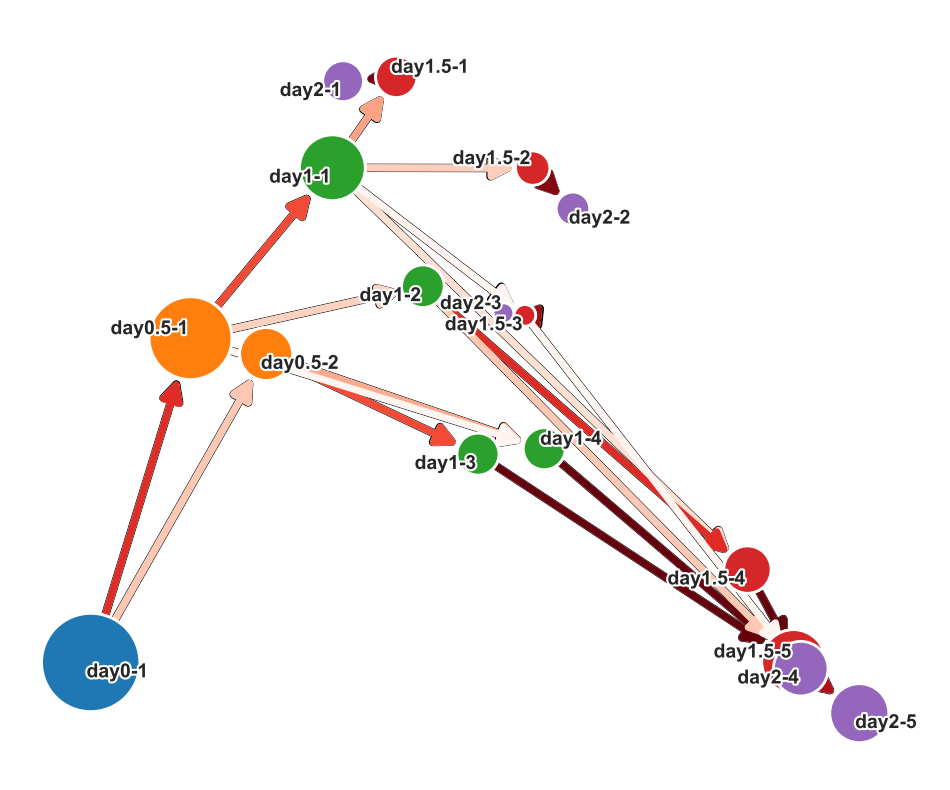

In [23]:
G = scegot.make_cell_state_graph(cluster_names,threshold=0.1)
scegot.plot_simple_cell_state_graph(
    G, layout="normal", save=True, save_path="../figure/Fig_CellStateGraph_PCA.png"
)

### Hierarchy

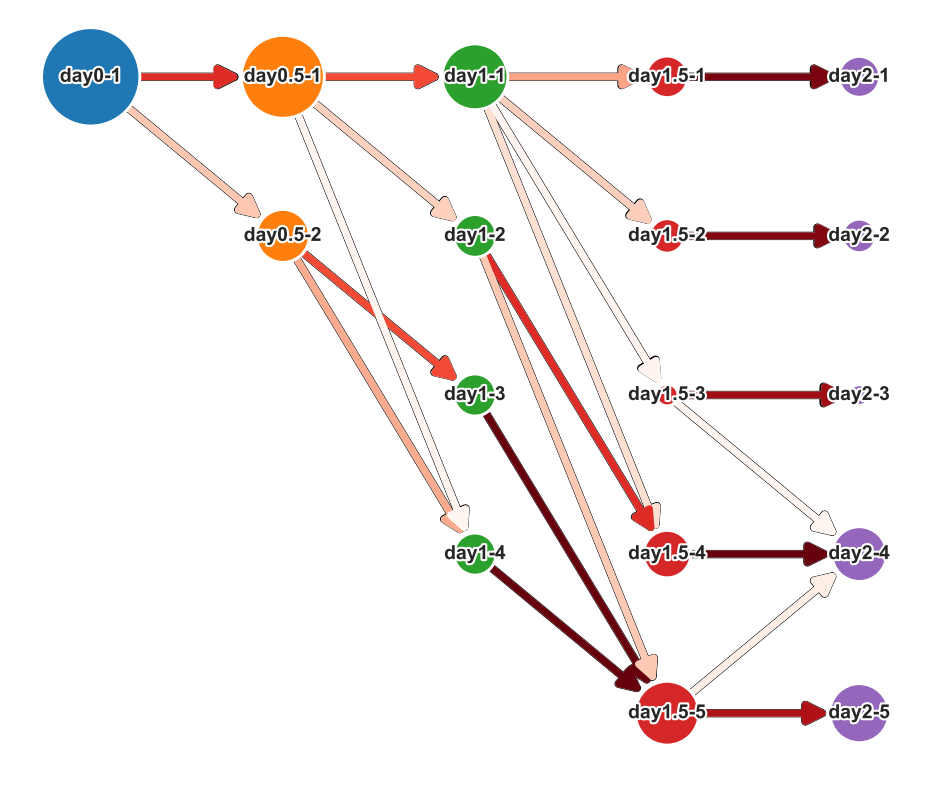

In [24]:
scegot.plot_simple_cell_state_graph(
    G,
    layout="hierarchy",
    save=True,
    save_path="../figure/Fig_CellStateGraph_hierarchy.png",
)

### UMAP

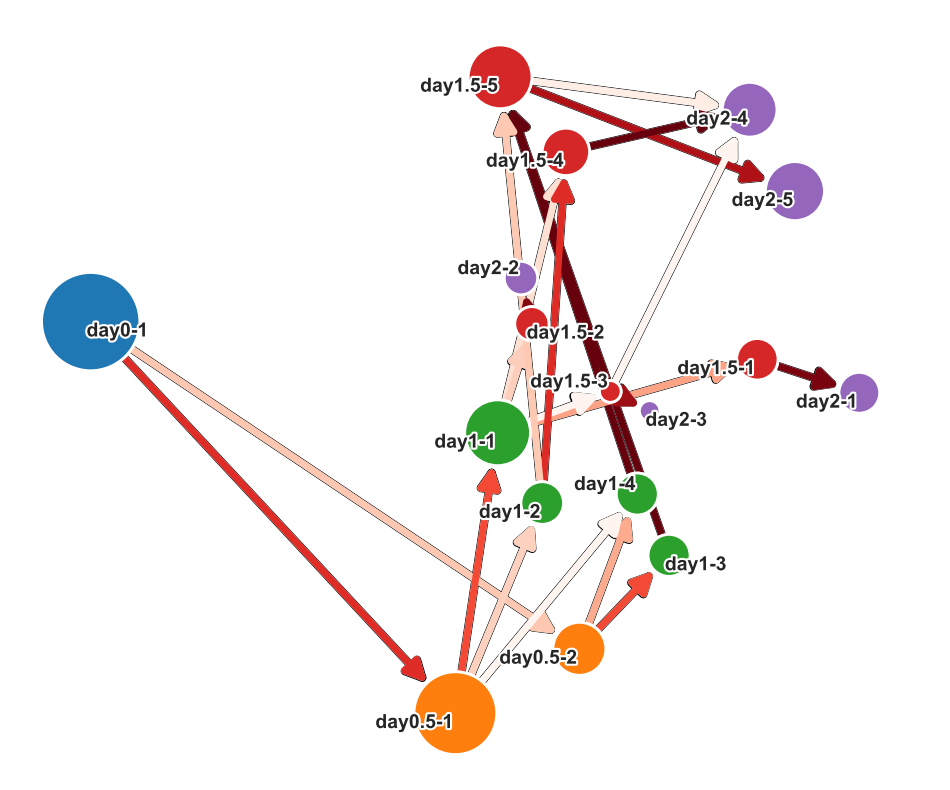

In [25]:
G_umap = scegot.make_cell_state_graph(cluster_names, mode="umap")
scegot.plot_simple_cell_state_graph(
    G_umap, save=True, save_path="../figure/Fig_CellStateGraph_UMAP.png"
)

### PAGA

In [26]:
adata.obs["day_float"] = adata.obs["cluster_day"].apply(lambda x: float(x[3:]))

In [27]:
annotation_dict = {
    "day0-0": "iMeLC",
    "day0.5-0": "transient mesoderm",
    "day0.5-1": "PGCLC precursor",
    "day1-0": "PGCLC precursor",
    "day1-1": "Early-ExMCLC",
    "day1-2": "Early-ExMCLC",
    "day1-3": "transient mesoderm",
    "day1.5-0": "ExMCLC",
    "day1.5-1": "PGCLC",
    "day1.5-2": "endoderm like cell",
    "day1.5-3": "amnion like cell",
    "day1.5-4": "ExMCLC",
    "day2-0": "ExMCLC",
    "day2-1": "PGCLC",
    "day2-2": "endoderm like cell",
    "day2-3": "amnion like cell",
    "day2-4": "ExMCLC",
}
cluster_names = scegot.generate_cluster_names_with_day()
cluster_names_each_sample = []
for i, day in enumerate(scegot.day_names):
    cluster_names_each_sample.append([])
    for label in scegot.gmm_labels[i]:
        cluster_names_each_sample[i].append(f"{day}-{label}")
adata.obs["cluster_name"] = list(
    itertools.chain.from_iterable(cluster_names_each_sample)
)
adata.obs["annotation"] = [
    annotation_dict[cls] for cls in adata.obs["cluster_name"]
]
adata.obs

sample  percent.mito  day cluster_day  \
iM.data_GTGGAAGGTCAATGGG-1    iM.data      0.056487   iM        day0   
iM.data_TTCATGTCAACCCGCA-1    iM.data      0.216231   iM        day0   
iM.data_GAGGGTATCCAGGACC-1    iM.data      0.076525   iM        day0   
iM.data_AAGTCGTAGGCTTTCA-1    iM.data      0.080264   iM        day0   
iM.data_ACCGTTCGTAACTTCG-1    iM.data      0.280788   iM        day0   
...                               ...           ...  ...         ...   
d2b.data_AAGCCATAGGGCGAGA-1  d2b.data      4.811476  d2b        day2   
d2b.data_CAACCAATCTTCCGTG-1  d2b.data      2.554428  d2b        day2   
d2b.data_AGGCCACGTGAGTAGC-1  d2b.data      3.142146  d2b        day2   
d2b.data_GATCAGTTCGAGTACT-1  d2b.data      4.287140  d2b        day2   
d2b.data_TCATCCGTCATGGGAG-1  d2b.data      2.835834  d2b        day2   

                            day_float cluster_name annotation  
iM.data_GTGGAAGGTCAATGGG-1        0.0       day0-0      iMeLC  
iM.data_TTCATGTCAACCCGCA-1        0.0       day0-0      iMeLC  
iM.data_GAGGGTATCCAGGACC-1        0.0       day0-0      iMeLC  
iM.data_AAGTCGTAGGCTTTCA-1        0.0       day0-0      iMeLC  
iM.data_ACCGTTCGTAACTTCG-1        0.0       day0-0      iMeLC  
...                               ...          ...        ...  
d2b.data_AAGCCATAGGGCGAGA-1       2.0       day2-4     ExMCLC  
d2b.data_CAACCAATCTTCCGTG-1       2.0       day2-1      PGCLC  
d2b.data_AGGCCACGTGAGTAGC-1       2.0       day2-4     ExMCLC  
d2b.data_GATCAGTTCGAGTACT-1       2.0       day2-4     ExMCLC  
d2b.data_TCATCCGTCATGGGAG-1       2.0       day2-4     ExMCLC  

[11771 rows x 7 columns]

In [28]:
%%time
sc.pp.normalize_total(adata, target_sum=target_sum)
sc.pp.log1p(adata)
sc.pp.pca(adata, n_comps=20, svd_solver='arpack', random_state=RANDOM_STATE)
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)

CPU times: user 1min 21s, sys: 58.4 s, total: 2min 19s
Wall time: 16.5 s


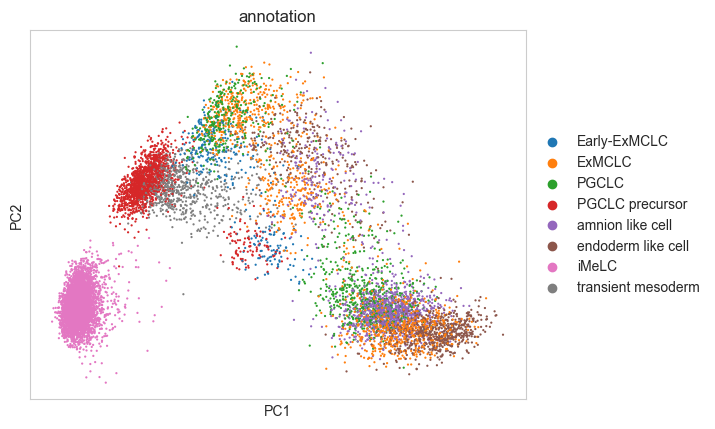

In [29]:
sc.pl.pca(adata, color=["annotation"])

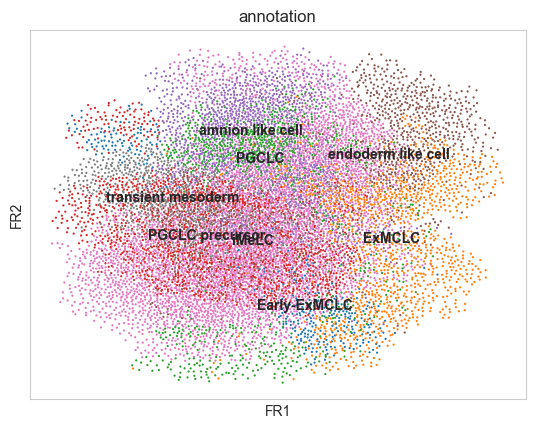

CPU times: user 1min 22s, sys: 281 ms, total: 1min 22s
Wall time: 1min 21s


In [30]:
%%time
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color="annotation", legend_loc="on data")

In [31]:
sc.tl.leiden(adata, random_state=RANDOM_STATE)
sc.tl.paga(adata, groups='leiden')

In [32]:
cluster_pos = np.array([
    adata.obsm["X_pca"][adata.obs["leiden"].astype(int) == leiden_label, :2].mean(axis=0)
    for leiden_label in np.unique(adata.obs["leiden"].astype(int))
])
cluster_pos

array([[-7.76900196e+00,  1.59677906e+01],
       [ 3.94831963e+01, -1.23840513e+01],
       [-2.01995182e+01, -8.50450420e+00],
       [ 3.23313141e+01, -1.18035774e+01],
       [-2.10749016e+01, -8.21006870e+00],
       [-9.71263599e+00,  1.28366976e+01],
       [-1.96726131e+01, -5.75720215e+00],
       [-3.75902629e+00,  1.16530180e+01],
       [-9.10395241e+00,  1.37239847e+01],
       [-2.02483768e+01, -9.32578373e+00],
       [ 2.95177860e+01, -8.35915661e+00],
       [-2.00102654e+01, -1.22219982e+01],
       [ 3.14168606e+01, -8.89083767e+00],
       [ 5.30705833e+00,  2.05426559e+01],
       [-1.99220657e+01, -8.75795460e+00],
       [-1.95021648e+01, -5.55712938e+00],
       [-1.93196430e+01, -5.19168472e+00],
       [-1.97160320e+01, -9.11337280e+00],
       [-1.95278358e+01, -3.60348392e+00],
       [ 2.78278770e+01, -7.26286125e+00],
       [ 2.95578880e+01, -8.39995575e+00],
       [-1.99049339e+01, -5.48008490e+00],
       [ 1.95317307e+01,  1.56296415e+01],
       [ 1.

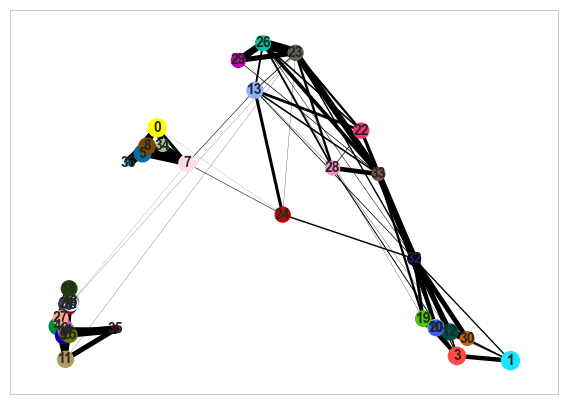

In [33]:
sc.pl.paga(adata, pos=cluster_pos)

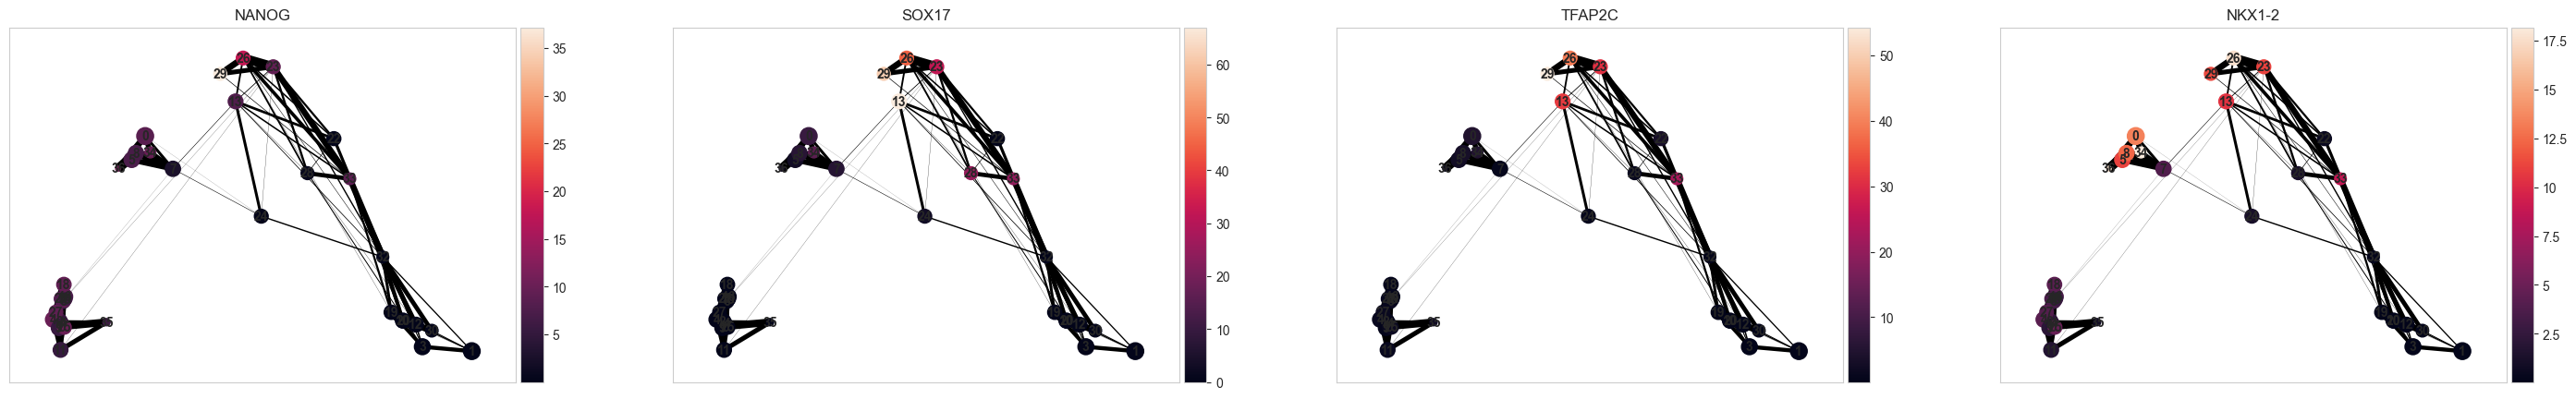

In [34]:
sc.pl.paga(adata, color=["NANOG", "SOX17", "TFAP2C", "NKX1-2"], pos=cluster_pos)

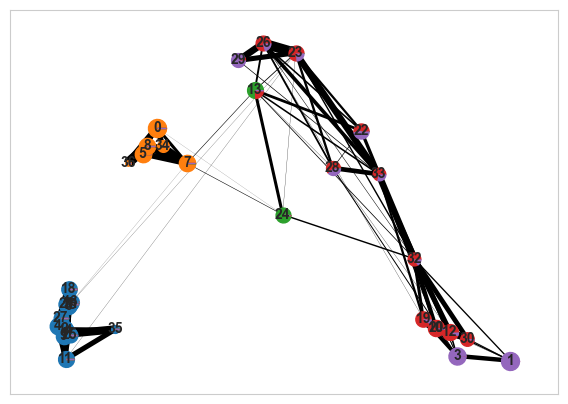

In [37]:
sc.pl.paga(adata, color=["cluster_day"], pos=cluster_pos, show=False)
plt.savefig("../figure/PAGA_graph.jpeg", bbox_inches="tight", dpi=300)